# Our validation - ideas + results confirmation

In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
with_fe_train= pd.read_csv('C:\\Users\\rogal\\UczenieMaszynowe\\Projekt2\\Walidacja2\\post_feature_engineering_train.csv', index_col=None)
with_fe_test = pd.read_csv('C:\\Users\\rogal\\UczenieMaszynowe\\Projekt2\\Walidacja2\\post_feature_engineering_test2.csv',index_col=None)

In [3]:
with_fe_test # nasza ramka do testowania

,seconds_elapsed,location_bearingAccuracy,location_speedAccuracy,location_verticalAccuracy,location_horizontalAccuracy,location_speed,location_bearing,location_altitude,location_longitude,location_latitude,...,Bandpass_Gyroscope_z,avg_steps_per_minute,bearing_east,bearing_north,bearing_south,bearing_west,combined_orientation,Total_Motion_Intensity,Gravity_Magnetometer_y_interaction,Gravity_Orientation_pitch_ratio
0,351.988000,21.500001,2.6,1.035250,3.900,0.395205,92.127159,68.599998,3.095426,50.688277,...,0.004951,0.000000,True,False,False,False,-0.023727,18.002959,-14.952563,-9.790013
1,78.412056,0.000000,0.0,6.363528,6.699,2.084059,315.506165,89.200005,3.139791,50.684868,...,-0.286395,84.170730,False,False,False,True,-0.865642,50.304606,-380.821190,-8.482901
2,771.097949,0.000000,0.0,1.055240,7.751,0.717536,142.522339,90.000000,3.152066,50.681880,...,-0.187927,106.134376,True,False,False,False,-1.234499,28.346709,-250.688916,-7.311745
3,328.574522,0.000000,0.0,1.228584,7.994,1.284345,102.234695,87.300003,3.146482,50.685465,...,-0.406713,107.738116,True,False,False,False,-0.698521,42.789231,-360.973372,-7.468350
4,271.752000,5.700000,1.0,30.814772,3.900,7.353899,274.938171,82.500000,3.098769,50.686902,...,-0.816570,104.433454,False,False,False,True,-0.135499,15.919612,-31.234479,-9.715313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689,466.098125,0.000000,0.0,15.400000,3.658,0.001336,0.000000,68.900000,3.111234,50.681033,...,0.762913,98.219661,False,True,False,False,-0.640401,28.407376,-30.133030,-9.717622
2690,951.271000,21.500001,3.9,1.469109,5.285,0.113767,335.953064,89.599998,3.152528,50.681563,...,0.054776,93.222646,False,False,False,True,0.505617,46.420563,-415.136369,-7.416683
2691,933.701806,0.000000,0.0,14.500000,6.781,3.123722,20.089300,71.900000,3.126475,50.675735,...,-0.349545,100.824481,False,True,False,False,-0.653496,37.788792,-160.888656,-9.410930
2692,314.854788,0.000000,0.0,19.700001,6.610,4.457863,322.790863,57.800000,3.119078,50.674101,...,-0.247453,102.523453,False,False,False,True,-0.737389,47.456021,-253.501862,-9.258339


In [4]:
# budowa robi Quantile transformer 
#wprowadzona przez nas zmiana również tu : rozdzielenie osobno na fit i transform, bo na ramce testowej nie chcemy już fit
transformer = QuantileTransformer(output_distribution='normal')
transformer.fit(with_fe_train) # trenujemy
df_transformed_test = pd.DataFrame(transformer.transform(with_fe_test), columns=with_fe_test.columns) # fitujemy na testową
df_transformed_train = pd.DataFrame(transformer.transform(with_fe_train), columns=with_fe_train.columns)

#spróbujmy równocześnie StandardScaler 
scaler = StandardScaler()
scaler.fit(with_fe_train)
df_scaled_test = pd.DataFrame(scaler.transform(with_fe_test), columns=with_fe_test.columns)
df_scaled_train = pd.DataFrame(scaler.transform(with_fe_train), columns=with_fe_train.columns)

### Podpowiedź do PCA:
zamiast

In [5]:
pca = PCA(n_components=len(df_transformed_train.columns))
pca.fit(df_transformed_train)

PCA(n_components=67)

In [6]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()
threshold = 0.90
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(num_components)

20


można użyć funkcji PCA:

In [7]:
pca = PCA(0.9)
pca.fit(df_transformed_train)
print(pca.n_components_)

20


<span style="color:orange">W tym momencie sprawdzamy funkcje klastrujące grupy budującej, którą musimy zmodyfikować aby nie robić fit na zbiorze testowym. Wywołamy KMeans bo na tym modelu skupia się grupa budująca </span>

In [8]:
pca = PCA(n_components=num_components)
pca.fit(df_transformed_train)
pca_components_train = pca.transform(df_transformed_train)  
pca_components_test = pca.transform(df_transformed_test)

# dla KMeans najlepsze scory były dla 3,4,5 klastrów
model1 = KMeans(n_clusters=3,random_state=42)
model1.fit(pca_components_train)
predictions1 = model1.predict(pca_components_test)

model2 = KMeans(n_clusters=4,random_state=42)
model2.fit(pca_components_train)
predictions2 = model2.predict(pca_components_test)

model3 = KMeans(n_clusters=5,random_state=42)
model3.fit(pca_components_train)
predictions3 = model3.predict(pca_components_test)

print("Wyniki na ramce testowej silhouette score dla KMeans 3,4 i 5 klastrów:")
print(silhouette_score(pca_components_test,predictions1))
print(silhouette_score(pca_components_test,predictions2))
print(silhouette_score(pca_components_test,predictions3))

Wyniki na ramce testowej silhouette score dla KMeans 3,4 i 5 klastrów:
0.30218517437226355
0.35941512305598267
0.3132937623301441


In [9]:
# zobaczmy dla ramki z użyciem Scaler:
pca = PCA(n_components=num_components)
pca.fit(df_scaled_train)
pca_components_train = pca.transform(df_scaled_train)  
pca_components_test = pca.transform(df_scaled_test)

# dla KMeans najlepsze scory były dla 3,4,5 klastrów
model1 = KMeans(n_clusters=3,random_state=42)
model1.fit(pca_components_train)
predictions1 = model1.predict(pca_components_test)

model2 = KMeans(n_clusters=4,random_state=42)
model2.fit(pca_components_train)
predictions2 = model2.predict(pca_components_test)

model3 = KMeans(n_clusters=5,random_state=42)
model3.fit(pca_components_train)
predictions3 = model3.predict(pca_components_test)

print("Wyniki na ramce testowej silhouette score dla KMeans 3,4 i 5 klastrów:")
print(silhouette_score(pca_components_test,predictions1))
print(silhouette_score(pca_components_test,predictions2))
print(silhouette_score(pca_components_test,predictions3))

Wyniki na ramce testowej silhouette score dla KMeans 3,4 i 5 klastrów:
0.1441291979032439
0.17088543695154704
0.1808284429030779


Wyniki dużo gorsze dla użycia StandardScaler, nie będziemy tego sugerować

Sprawdźmy wykresy:

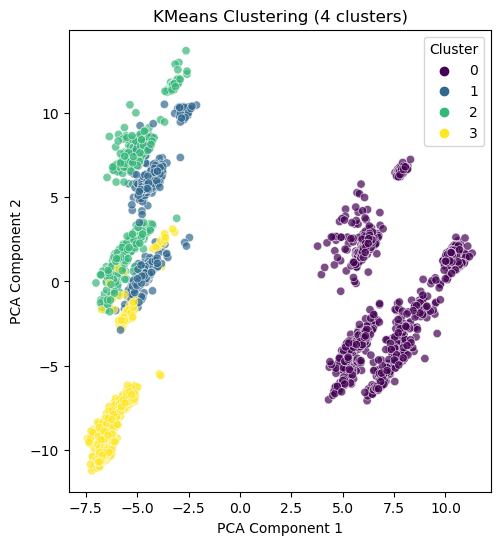

In [10]:
#podstawiamy ramkę testową i model :
pca = PCA(n_components=20)
pca.fit(df_transformed_train)
pca_components_train = pca.transform(df_transformed_train)
pca_components_test=pca.transform(df_transformed_test)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_components_train)
labels_kmeans = kmeans.predict(pca_components_test)

#funkcja grupy budującej
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_components_test[:, 0], y=pca_components_test[:, 1], hue=labels_kmeans, palette='viridis', alpha=0.7)
plt.title('KMeans Clustering (4 clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')

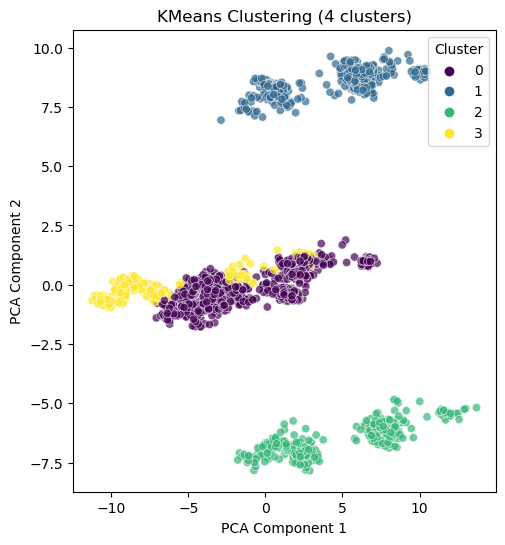

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_components_test[:, 1], y=pca_components_test[:, 2], hue=labels_kmeans, palette='viridis', alpha=0.7)
plt.title('KMeans Clustering (4 clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')

Wykresy wychodzą tak samo jak na ramce train

In [12]:
import pandas as pd

# Zakładając, że df_transformed ma 67 kolumn przed PCA
original_columns = df_transformed_test.columns[:67]

# Obliczenie współczynników PCA (loadings)
pca_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(num_components)], index=original_columns)
for i in range(num_components):
    print(f'\nNajważniejsze cechy dla PC{i+1}:')
    print(pca_loadings.iloc[:, i].nlargest(5))  # Największe wartości
    print(pca_loadings.iloc[:, i].nsmallest(5))  # Najmniejsze wartości


Najważniejsze cechy dla PC1:
bearing_north             0.770809
location_speedAccuracy    0.123541
Orientation_qx            0.078843
Gravity_y                 0.056986
TotalAcceleration_y       0.056606
Name: PC1, dtype: float64
bearing_east           -0.323218
location_bearing       -0.286671
bearing_south          -0.263330
bearing_west           -0.184261
avg_steps_per_minute   -0.173855
Name: PC1, dtype: float64

Najważniejsze cechy dla PC2:
location_bearingAccuracy    0.461052
location_speedAccuracy      0.392533
bearing_south               0.378070
bearing_west                0.221306
pitch_roll_ratio            0.088209
Name: PC2, dtype: float64
bearing_east           -0.492810
Orientation_roll       -0.144992
avg_steps_per_minute   -0.131086
bearing_north          -0.106566
Orientation_qw         -0.104408
Name: PC2, dtype: float64

Najważniejsze cechy dla PC3:
bearing_west                0.710905
location_bearing            0.089953
location_bearingAccuracy    0.074970
Total

Wyniki takie same jak dla zbioru treningowego

In [13]:
#sprawdzenie statystyk
df_transformed_test['Cluster_KMeans'] = labels_kmeans
cluster_means_kmeans = df_transformed_test.groupby('Cluster_KMeans').mean()
cluster_means_kmeans

,seconds_elapsed,location_bearingAccuracy,location_speedAccuracy,location_verticalAccuracy,location_horizontalAccuracy,location_speed,location_bearing,location_altitude,location_longitude,location_latitude,...,Bandpass_Gyroscope_z,avg_steps_per_minute,bearing_east,bearing_north,bearing_south,bearing_west,combined_orientation,Total_Motion_Intensity,Gravity_Magnetometer_y_interaction,Gravity_Orientation_pitch_ratio
Cluster_KMeans,,,,,,,,,,,,,,,,,,,,,
0,0.101511,-3.454480,-1.541240,0.190549,-0.112244,-0.879282,-2.838802,0.013626,-0.206095,0.155721,...,-0.003806,-1.624765,-5.199338,5.199338,-5.199338,-5.199338,-0.016586,0.021375,0.123071,-0.143325
1,-0.262310,-0.561923,-1.285242,0.286846,-0.217841,0.722796,1.526980,-0.504814,-0.230930,-0.268882,...,0.017877,-0.452849,-5.199338,-5.199338,-5.199338,5.199338,-0.208196,0.647493,-0.307973,-0.175412
2,-0.589545,-0.903170,-1.586213,0.863092,-0.070302,0.512761,0.599584,-0.137185,-0.045493,-0.155556,...,-0.016495,-0.045446,-5.199338,-5.199338,5.199338,-5.199338,0.599818,-0.337580,0.161506,-0.038910
3,0.482788,-4.052677,-4.274280,-0.210230,0.738769,-0.083405,0.032537,0.541861,0.613916,-0.515335,...,0.012975,0.289134,5.199338,-5.199338,-5.199338,-5.199338,-0.433040,-0.240986,-0.084438,0.449507


Ostateczny wynik na ramce testowej:

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_components_train)
labels_kmeans = kmeans.predict(pca_components_test)
print(silhouette_score(pca_components_test,labels_kmeans))

0.3594149069133492


Grupa walidacyjna używa modelu XGBoost aby zobaczyć feature importance:

In [16]:
#sprawdźmy ich wyniki:
#grupa budująca w tym momencie wraca znów na ramkę bez nowych cech 
final_df_train = pd.read_csv('C:\\Users\\rogal\\UczenieMaszynowe\\Projekt2\\Walidacja2\\pre_feature_engineering_train.csv')
final_df_test = pd.read_csv("C:\\Users\\rogal\\UczenieMaszynowe\\Projekt2\\Walidacja2\\csv_do_walidacji.csv")

# Separacja kolumn 'time' oraz 'label'
time_label_test = final_df_test[['time', 'label']]
features_df_test = final_df_test.drop(columns=['time', 'label'])

time_label_train = final_df_train[['time', 'label']]
features_df_train = final_df_train.drop(columns=['time', 'label'])

# Usuwanie outlierów (zastąpienie wartości poniżej 5 centyla i powyżej 95 centyla)
lower_bound = features_df_train.quantile(0.05)
upper_bound = features_df_train.quantile(0.95)
features_df_train = features_df_train.clip(lower=lower_bound, upper=upper_bound, axis=1)
features_df_test = features_df_test.clip(lower=lower_bound, upper=upper_bound, axis=1)

# Normalizacja danych (bez 'time' oraz 'label')
scaler = StandardScaler()
scaler.fit(features_df_train)
normalized_features_train = scaler.transform(features_df_train)
normalized_features_test = scaler.transform(features_df_test)

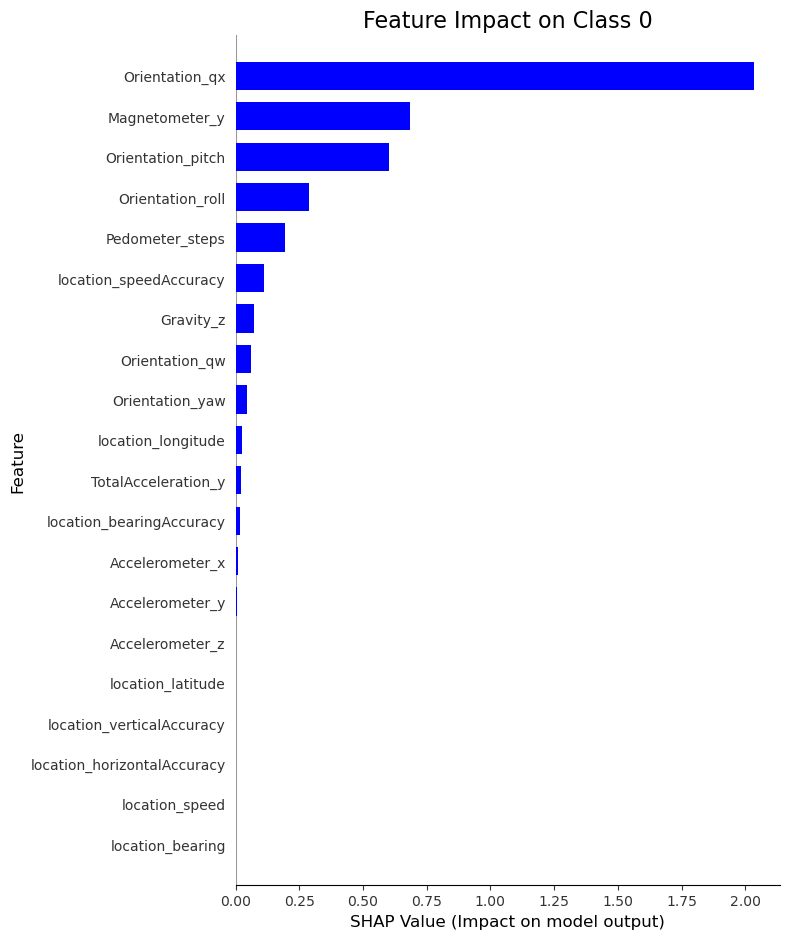

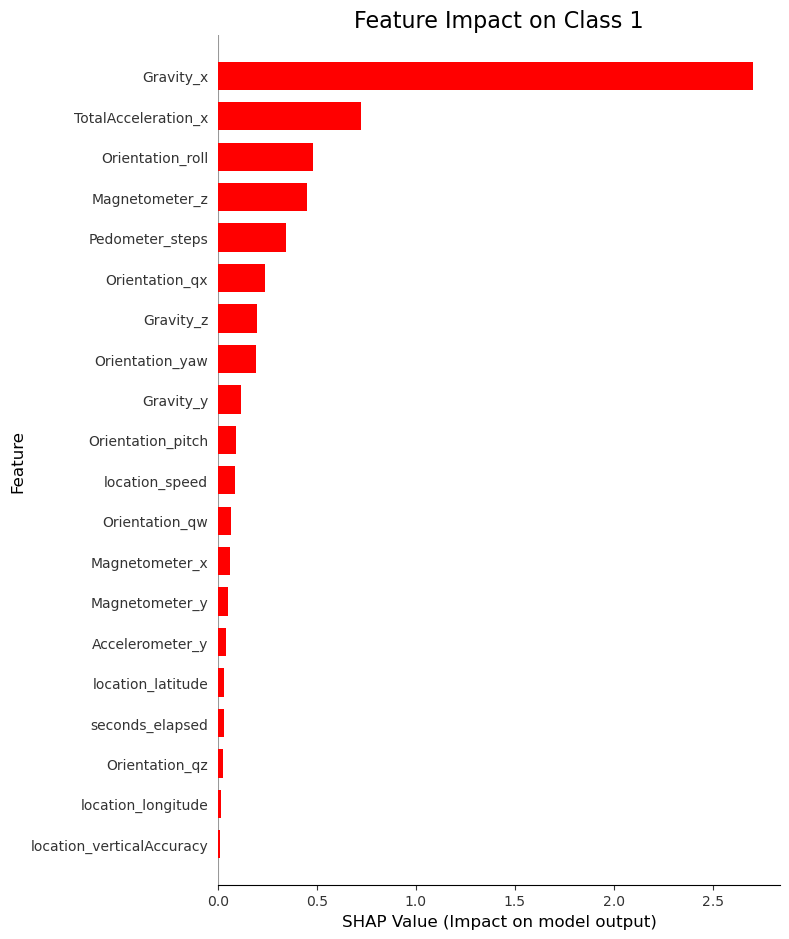

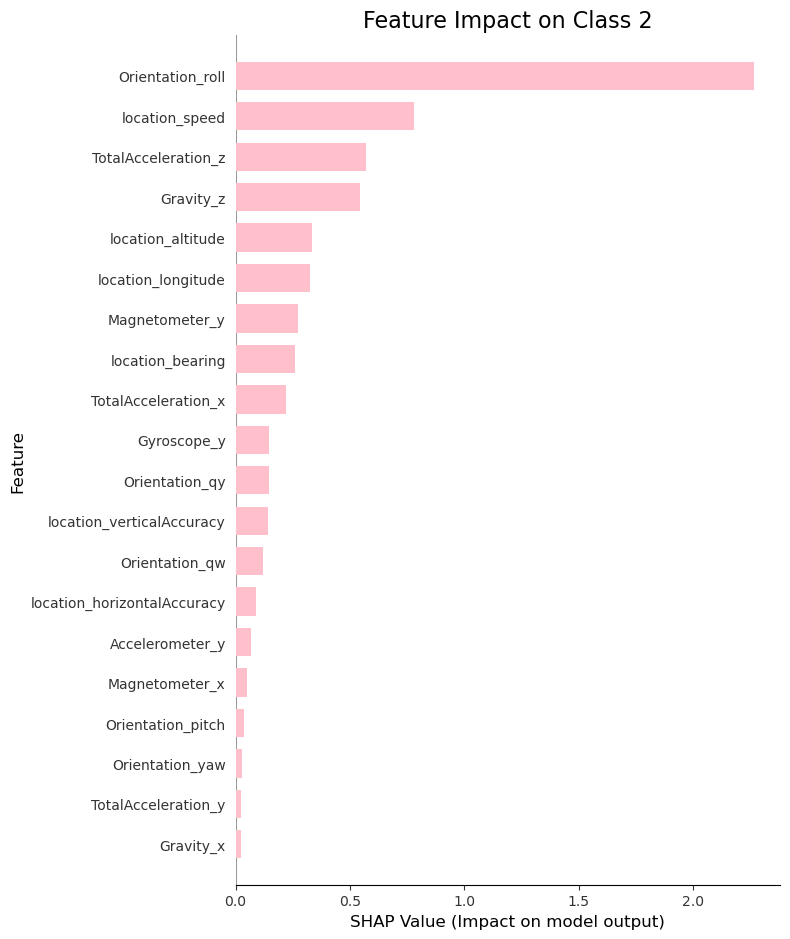

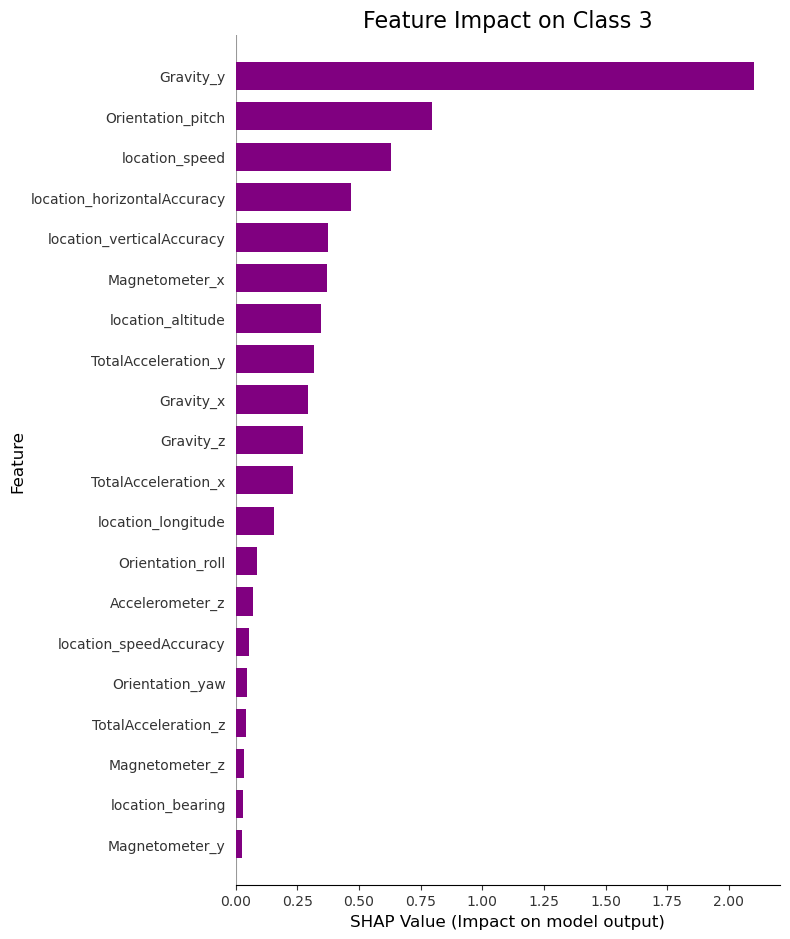

In [17]:
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


kmeans = KMeans(n_clusters=4 ,random_state=42)
kmeans.fit(normalized_features_train)
kmeans_labels = kmeans.predict(normalized_features_test)
final_df_test['cluster_label'] = kmeans_labels

# Podział danych na zbiór treningowy i testowy dla modelu klasyfikacyjnego
X_train, X_test, y_train, y_test = train_test_split(normalized_features_test, kmeans_labels, test_size=0.2, random_state=42)

# Trenuj model klasyfikacyjny XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

explainer=shap.Explainer(xgb_model)
shap_values=explainer(X_train)
np.shape(shap_values.values)
colors = ['blue', 'red', 'pink', 'purple', 'green']

for i in range(4):
    fig, ax = plt.subplots()
    shap.summary_plot(shap_values[:,:,i], features_df_test, plot_type="bar", color=colors[i], show=False)
    plt.title(f'Feature Impact on Class {i}', fontsize=16)
    plt.xlabel('SHAP Value (Impact on model output)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    # Usuwanie napisu na dole
    for text in plt.gca().texts:
        text.set_visible(False)
    # Ustawienia osi i etykiety
    plt.gca().tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()


Lets try random  forest feature importances

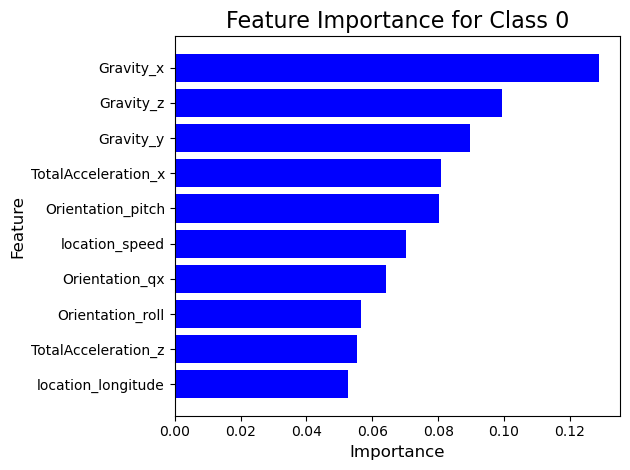

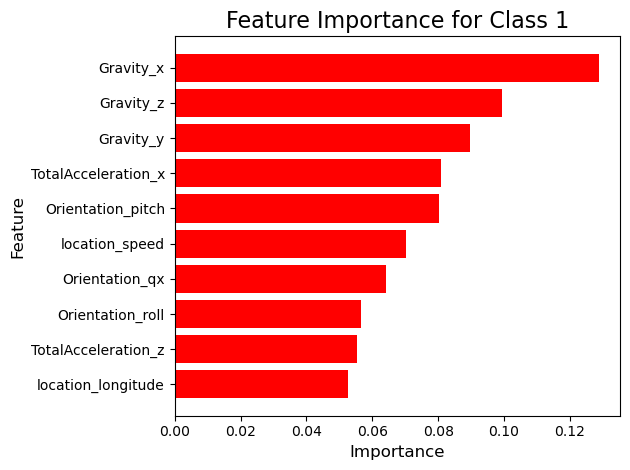

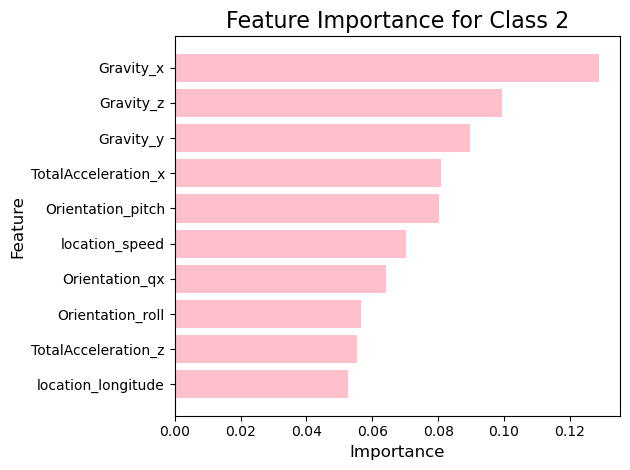

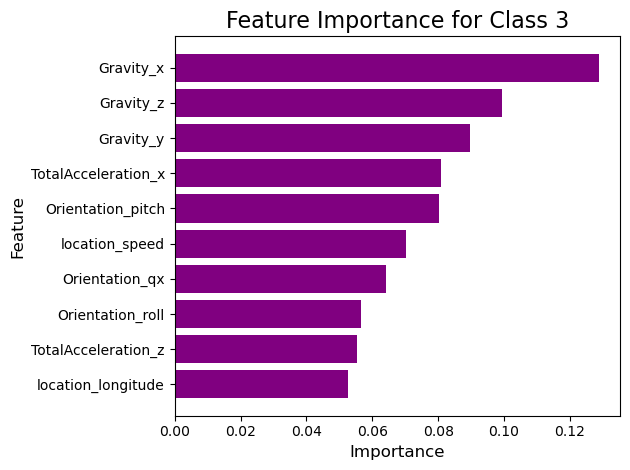

In [18]:
from sklearn.ensemble import RandomForestClassifier


kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(normalized_features_train)
kmeans_labels = kmeans.predict(normalized_features_test)
final_df_test['cluster_label'] = kmeans_labels

# Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(normalized_features_test, kmeans_labels, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances from Random Forest
feature_importances = rf_model.feature_importances_

# Creating a DataFrame for feature importances
features_df = pd.DataFrame({
    'Feature': features_df_test.columns,
    'Importance': feature_importances
})

# Sorting features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
colors = ['blue', 'red', 'pink', 'purple', 'green']

for i in range(4):
    fig, ax = plt.subplots()
    selected_features = features_df.head(10)  # Selecting top 10 features for better visualization
    ax.barh(selected_features['Feature'], selected_features['Importance'], color=colors[i])
    plt.title(f'Feature Importance for Class {i}', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.gca().tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()

 97%|=================== | 8399/8620 [00:33<00:00]       

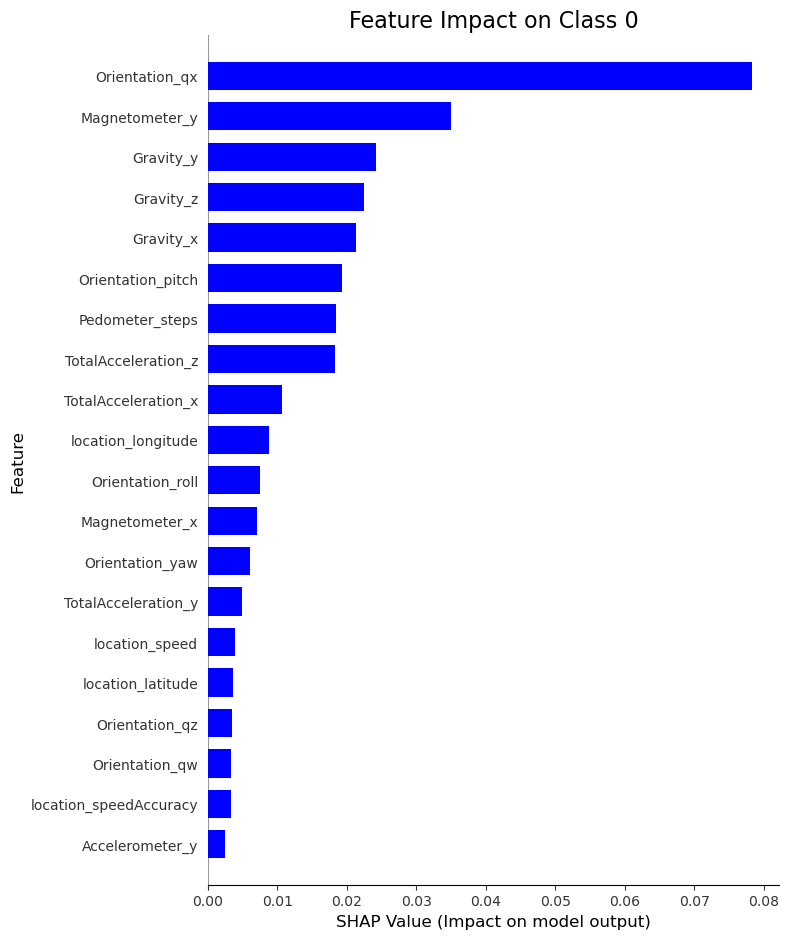

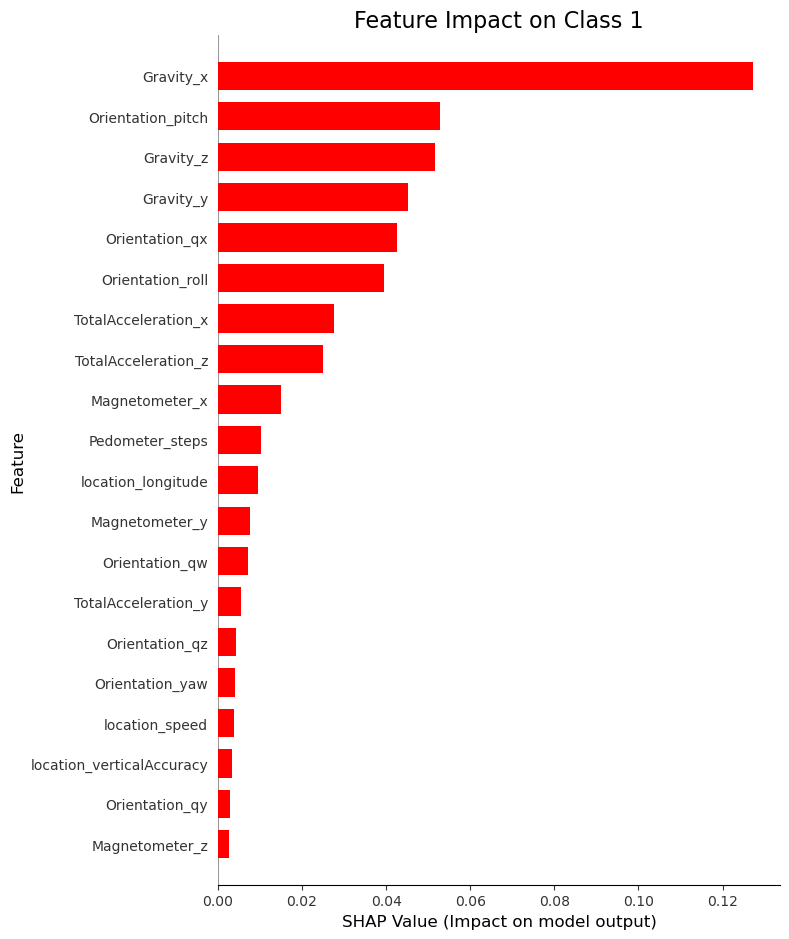

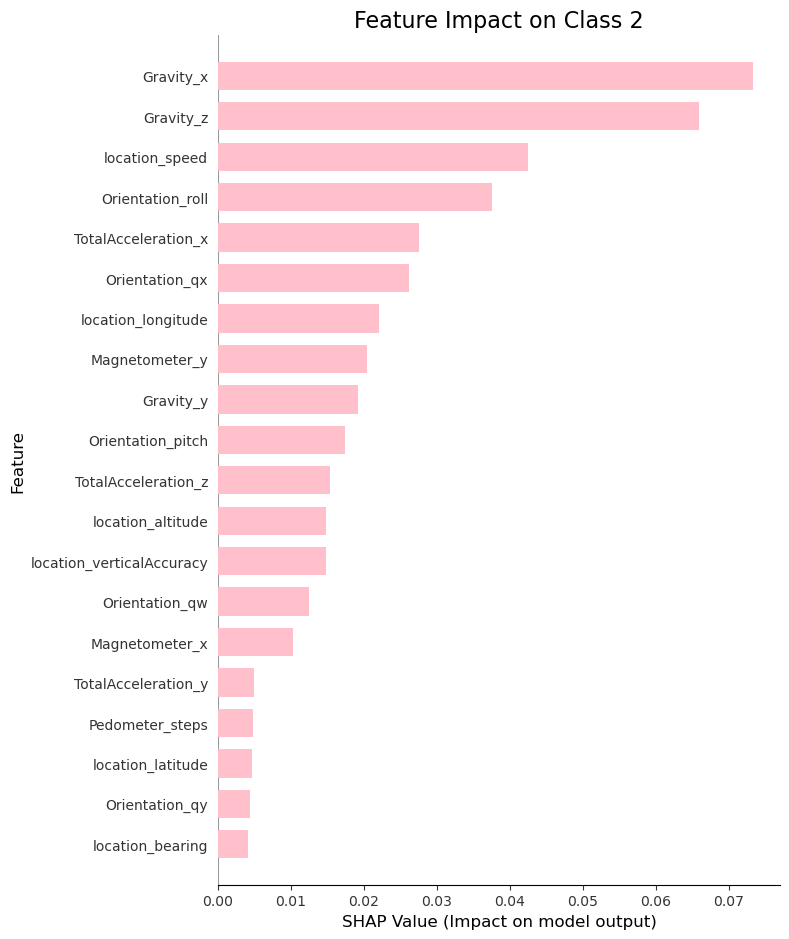

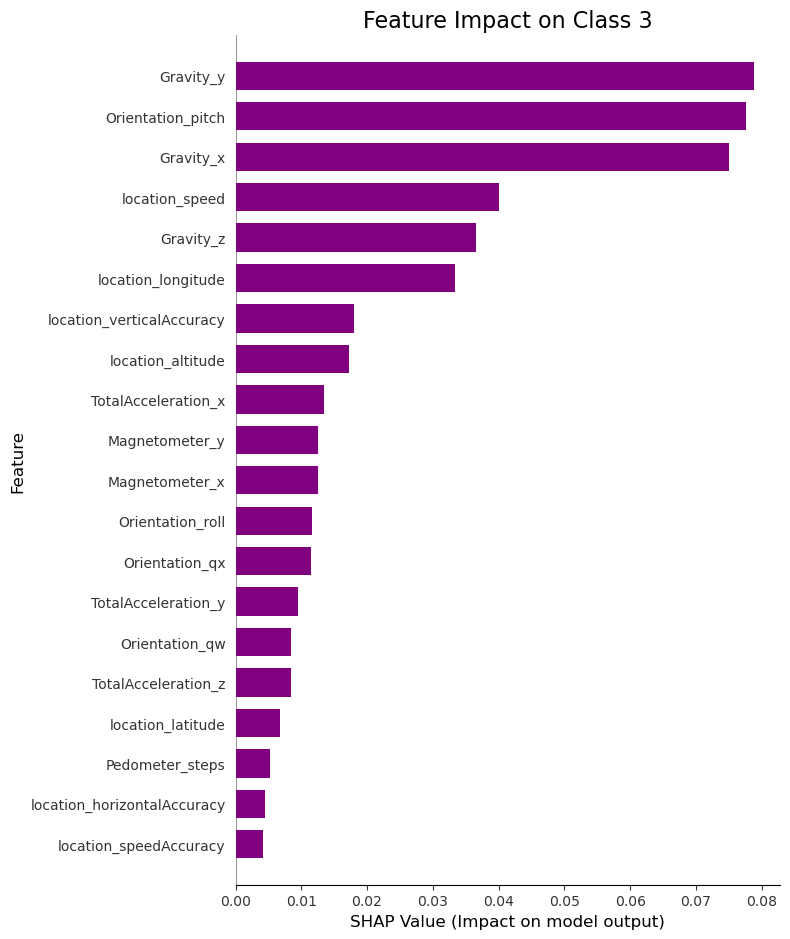

In [19]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming normalized_features_train, normalized_features_test, and features_df_test are already defined

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(normalized_features_train)
kmeans_labels = kmeans.predict(normalized_features_test)
final_df_test['cluster_label'] = kmeans_labels

# Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(normalized_features_test, kmeans_labels, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Calculate SHAP values
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_train)

# Plot SHAP values
colors = ['blue', 'red', 'pink', 'purple', 'green']

for i in range(4):
    fig, ax = plt.subplots()
    shap.summary_plot(shap_values[:, :, i], features_df_test, plot_type="bar", color=colors[i], show=False)
    plt.title(f'Feature Impact on Class {i}', fontsize=16)
    plt.xlabel('SHAP Value (Impact on model output)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    # Remove text at the bottom
    for text in plt.gca().texts:
        text.set_visible(False)
    # Set axis and label settings
    plt.gca().tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()


Ciekawe wyniki - dla każdego klastra najważniejsze są cechy grawitacyjne, jednak Shap values podobne jak wcześniej dla XGBOOST

### Ostateczne wykresy ? dalej w kodzie było zamieszanie - po dyskusji z grupą budującą tu zakończymy, wybrany model to powyższy KMeans 4 klastry